#IMPORTING REQUIRED MODULES

In [ ]:
!pip install -U -q PyDrive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from PIL import Image
import gym
from gym import spaces
from google.colab.patches import cv2_imshow

import random
from random import randrange
import ipywidgets as widgets

import os,sys
import imageio

from google.colab import drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from google.colab import files

#HORIZONTAL RECTANGLE CLASS

In [ ]:
class Horiz_Rectangle(gym.Env):
  metadata={'render.modes':['human']}

  def __init__(self):

    #Coordinates for the block green:
    z=np.random.randint(0,9)
    self.x_cell_size=([z,z+1])
    self.y_cell_size=np.random.randint(0,10)

    #Coordinates check for out of bound of output window(10x10):
    if self.x_cell_size[0] < 0:
        self.x_cell_size[0] = 0
    if self.x_cell_size[1] < 0:
        self.x_cell_size[1] = 1
    if self.x_cell_size[0] > 9:
        self.x_cell_size[0] = 8
    if self.x_cell_size[1] > 9:
        self.x_cell_size[1] = 9
        
    if self.y_cell_size < 0:
        self.y_cell_size = 0
    if self.y_cell_size> 9:
        self.y_cell_size= 9

    #Initializing state and centroid of the object:
    self.state=[[self.x_cell_size[0],self.y_cell_size],[self.x_cell_size[1],self.y_cell_size]]
    self.state_original=[[self.x_cell_size[0],self.y_cell_size],[self.x_cell_size[1],self.y_cell_size]]
    self.centroid_x_cell_size=(((2*z)+1)/2) + 0.5
    self.centroid_y_cell_size=self.y_cell_size+0.5
    self.centroid_state=self.centroid_x_cell_size,self.centroid_y_cell_size
    
  #Function to check the overlapping of machines:
  #If machines are overlapped, reset the position of the machine.
  def compare_elements(self,other):
    bflag=False
    for x in range(len(self.state)):
      for y in range(len(other.state)):
          if self.state[x] == other.state[y]:
              z=np.random.randint(0,9)
              self.x_cell_size=([z,z+1])
              self.y_cell_size=np.random.randint(0,10)
              self.state=[[self.x_cell_size[0],self.y_cell_size],[self.x_cell_size[1],self.y_cell_size]]
              self.state_original=[[self.x_cell_size[0],self.y_cell_size],[self.x_cell_size[1],self.y_cell_size]]
              self.centroid_x_cell_size=(((2*z)+1)/2) + 0.5
              self.centroid_y_cell_size=self.y_cell_size+0.5
              self.centroid_state=self.centroid_x_cell_size,self.centroid_y_cell_size
              bflag=True     
          else:
              self.state=self.state
              self.state_original=[[self.x_cell_size[0],self.y_cell_size],[self.x_cell_size[1],self.y_cell_size]]
    return self.state,bflag
    
  #Step function:
  def step(self,action):
    if action==0: #move left
        self.x_cell_size[0]=self.x_cell_size[0]-1
        self.x_cell_size[1]=self.x_cell_size[1]-1
    elif action==1: #move right
        self.x_cell_size[0]=self.x_cell_size[0]+1
        self.x_cell_size[1]=self.x_cell_size[1]+1
    elif action==2: #move up
        self.y_cell_size=self.y_cell_size-1
    elif action==3: #move down
        self.y_cell_size=self.y_cell_size+1
      
  #Coordinates check for out of bound after step
    if self.x_cell_size[0] < 0:
        self.x_cell_size[0] = 0
    if self.x_cell_size[1] < 1:
        self.x_cell_size[1] = 1
    if self.x_cell_size[0]> 8:
        self.x_cell_size[0]= 8
    if self.x_cell_size[1] > 9:
        self.x_cell_size[1] = 9
        
    if self.y_cell_size < 0:
        self.y_cell_size = 0
    if self.y_cell_size> 9:
        self.y_cell_size= 9
      
    #initializing new state and new centroid of the object based on action
    self.state=self.state=[[self.x_cell_size[0],self.y_cell_size],[self.x_cell_size[1],self.y_cell_size]]
    z=self.x_cell_size[0]
    self.centroid_x_cell_size=((2*z)+1)/2+0.5
    self.centroid_y_cell_size=self.y_cell_size+0.5
    self.centroid_state_new=self.centroid_x_cell_size,self.centroid_y_cell_size

    return self.state

  #Function to count overlapping of machine after step:
  #If the machines are overlapped after step function,the overlapping penalty is added to the reward
  def com_after_step(self,other):
    bflag=False
    for x in range(len(self.state)):
      for y in range(len(other.state)):
          if self.state[x] == other.state[y]:
              bflag=True     
    return bflag

  #Function to calculate the distance between two machines:
  def cal_distance(self,other):
    point_1=np.array((self.centroid_x_cell_size,self.centroid_y_cell_size),dtype=np.float64)
    point_2=np.array((other.centroid_x_cell_size,other.centroid_y_cell_size),dtype=np.float64)
    dist = round(np.linalg.norm(point_1-point_2),3)
    return dist

  #Function to reset the machine to original position:         
  def reset_2(self):
    self.x_cell_size[0],self.y_cell_size=self.state_original[0][0], self.state_original[0][1]
    self.x_cell_size[1],self.y_cell_size=self.state_original[1][0], self.state_original[1][1]
    self.state=[[self.x_cell_size[0],self.y_cell_size],[self.x_cell_size[1],self.y_cell_size]]
    z=self.x_cell_size[0]
    self.centroid_x_cell_size=((2*z)+1)/2+0.5
    self.centroid_y_cell_size=self.y_cell_size+0.5
    return self.state   

#VERTICAL RECTANGLE CLASS

In [ ]:
class Vert_Rectangle(gym.Env):
  metadata={'render.modes':['human']}

  def __init__(self):

    #Coordinates for the block blue:
    a=np.random.randint(1,10)
    self.y_cell_size=a
    self.y1_cell_size=a-1
    self.x_cell_size=np.random.randint(0,10)

    #Coordinates check for out of bound of output window(10x10):
    if self.x_cell_size < 0:
        self.x_cell_size = 0
    if self.x_cell_size> 9:
        self.x_cell_size= 9

    if self.y_cell_size< 1:
        self.y_cell_size= 1
    if self.y1_cell_size < 0:
        self.y1_cell_size = 0
    if self.y_cell_size> 9:
        self.y_cell_size= 9
    if self.y1_cell_size> 8:
        self.y1_cell_size= 8

    #Initializing state and centroid of the object:
    self.state=[[self.x_cell_size,self.y1_cell_size],[self.x_cell_size,self.y_cell_size]]
    self.state_original=[[self.x_cell_size,self.y1_cell_size],[self.x_cell_size,self.y_cell_size]]
    self.centroid_x_cell_size=self.x_cell_size+0.5
    self.centroid_y_cell_size=((2*a)-1)/2+0.5
    self.centroid_state=self.centroid_x_cell_size,self.centroid_y_cell_size

  #Function to check the overlapping of machines:
  #If machines are overlapped, reset the position of the machine
  def compare_elements(self,other):
    bflag=False
    for x in range(len(self.state)):
      for y in range(len(other.state)):
        if self.state[x] == other.state[y]:
          a=np.random.randint(1,10)
          self.x_cell_size=np.random.randint(0,10)
          self.y_cell_size=a
          self.y1_cell_size=a-1
          self.state=[[self.x_cell_size,self.y1_cell_size],[self.x_cell_size,self.y_cell_size]]
          self.state_original=[[self.x_cell_size,self.y1_cell_size],[self.x_cell_size,self.y_cell_size]]
          self.centroid_x_cell_size=self.x_cell_size+0.5
          self.centroid_y_cell_size=((2*a)-1)/2+0.5
          self.centroid_state=self.centroid_x_cell_size,self.centroid_y_cell_size
          bflag=True      
        else:
          self.state=self.state
          self.state_original=[[self.x_cell_size,self.y1_cell_size],[self.x_cell_size,self.y_cell_size]]
    return self.state,bflag

  #Step function:
  def step(self,action):     
    if action==0: #move left
        self.x_cell_size=self.x_cell_size-1
    elif action==1: #move right
        self.x_cell_size=self.x_cell_size+1
    elif action==2: #move up
        self.y1_cell_size=self.y1_cell_size-1
        self.y_cell_size=self.y_cell_size-1
    elif action==3: #move down
        self.y_cell_size=self.y_cell_size+1
        self.y1_cell_size=self.y1_cell_size+1

    #Coordinates check for out of bound after step:  
    if self.x_cell_size < 0:
        self.x_cell_size = 0
    if self.x_cell_size> 9:
        self.x_cell_size= 9
        
    if self.y1_cell_size< 0:
        self.y1_cell_size= 0
    if self.y_cell_size < 1:
        self.y_cell_size = 1
    if self.y1_cell_size> 8:
        self.y1_cell_size= 8
    if self.y_cell_size> 9:
        self.y_cell_size= 9

    #Initializing new state and new centroid of the object based on action:
    self.state=[[self.x_cell_size,self.y1_cell_size],[self.x_cell_size,self.y_cell_size]]
    a=self.y_cell_size
    self.centroid_x_cell_size=self.x_cell_size+0.5
    self.centroid_y_cell_size=((2*a)-1)/2+0.5
    self.centroid_state_new=self.centroid_x_cell_size,self.centroid_y_cell_size
    return self.state

  #Function to count overlapping of machine after step:
  #If the machines are overlapped after step function,the overlapping penalty is added to the reward
  def com_after_step(self,other):
    bflag=False
    for x in range(len(self.state)):
      for y in range(len(other.state)):
          if self.state[x] == other.state[y]:
              bflag=True
    return bflag        
        
  #Function to calculate the distance between two machines:
  def cal_distance(self,other):
    point_1=np.array((self.centroid_x_cell_size,self.centroid_y_cell_size),dtype=np.float64)
    point_2=np.array((other.centroid_x_cell_size,other.centroid_y_cell_size),dtype=np.float64)
    dist = round(np.linalg.norm(point_1-point_2),3)
    return dist

  #Function to reset the machine to original position:  
  def reset_2(self):
    self.x_cell_size,self.y1_cell_size=self.state_original[0][0], self.state_original[0][1]
    self.x_cell_size,self.y_cell_size=self.state_original[1][0], self.state_original[1][1]
    self.state=[[self.x_cell_size,self.y1_cell_size],[self.x_cell_size,self.y_cell_size]]
    a=self.y_cell_size
    self.centroid_x_cell_size=self.x_cell_size+0.5
    self.centroid_y_cell_size=((2*a)-1)/2+0.5
    return self.state

#SMALL SQUARE CLASS

In [ ]:
class Square(gym.Env):
  metadata={'render.modes':['human']}

  def __init__(self):

    #Coordinates for the block red:
    self.x_cell_size=np.random.randint(0,10)
    self.y_cell_size=np.random.randint(0,10)
    
    #Coordinates check for out of bound for output window(10x10):
    if self.x_cell_size < 0:
        self.x_cell_size = 0
    if self.x_cell_size> 9:
        self.x_cell_size= 9
    if self.y_cell_size< 0:
        self.y_cell_size = 0
    if self.y_cell_size> 9:
        self.y_cell_size= 9
    
    #Initializing state and centroid of the object:
    self.state=[[self.x_cell_size,self.y_cell_size]]
    self.state_original=[[self.x_cell_size,self.y_cell_size]]
    self.centroid_x_cell_size=self.x_cell_size+0.5
    self.centroid_y_cell_size=self.y_cell_size+0.5
    self.centroid_state=self.centroid_x_cell_size,self.centroid_y_cell_size
    
  #Function to check the overlapping of machines:
  #If machines are overlapped, reset the position of the machine
  def compare_elements(self,other):
    bflag=False
    for x in range(len(self.state)):
      for y in range(len(other.state)):
          if self.state[x] == other.state[y]:
              self.x_cell_size=np.random.randint(0,10)
              self.y_cell_size=np.random.randint(0,10)
              self.state=[[self.x_cell_size,self.y_cell_size]]
              self.state_original=[[self.x_cell_size,self.y_cell_size]]
              self.centroid_x_cell_size=self.x_cell_size+0.5
              self.centroid_y_cell_size=self.y_cell_size+0.5
              self.centroid_state=self.centroid_x_cell_size,self.centroid_y_cell_size
              bflag=True
          else:
              self.state=self.state
              self.state_original=[[self.x_cell_size,self.y_cell_size]]
    return self.state,bflag

  #Step function:
  def step(self,action):
    if action==0: #move left
        self.x_cell_size=self.x_cell_size-1
    elif action==1: #move right
        self.x_cell_size=self.x_cell_size+1
    elif action==2: #move up
        self.y_cell_size=self.y_cell_size-1
    elif action==3: #move down
        self.y_cell_size=self.y_cell_size+1
    
    #Coordinates check for out of bound after step:
    if self.x_cell_size < 0:
        self.x_cell_size = 0
    if self.x_cell_size> 9:
        self.x_cell_size= 9
    if self.y_cell_size < 0:
        self.y_cell_size = 0
    if self.y_cell_size> 9:
        self.y_cell_size= 9
    
    #Initializing new state and new centroid of the object based on action:
    self.state=[[self.x_cell_size,self.y_cell_size]]
    self.centroid_x_cell_size=self.x_cell_size+0.5
    self.centroid_y_cell_size=self.y_cell_size+0.5
    self.centroid_state_new=self.centroid_x_cell_size,self.centroid_y_cell_size
    return self.state

  #Function to count overlapping of machine after step:
  #If the machines are overlapped after step function,the overlapping penalty is added to the reward
  def com_after_step(self,other):
    bflag=False
    for x in range(len(self.state)):
      for y in range(len(other.state)):
          if self.state[x] == other.state[y]:
              bflag=True
    return bflag
            
  #Function to calculate the distance between two machines:
  def cal_distance(self,other):
    point_1=np.array((self.centroid_x_cell_size,self.centroid_y_cell_size),dtype=np.float64)
    point_2=np.array((other.centroid_x_cell_size,other.centroid_y_cell_size),dtype=np.float64)
    dist = round(np.linalg.norm(point_1-point_2),3)
    return dist

  #Function to reset the machine to original position:    
  def reset_2(self):
    self.x_cell_size,self.y_cell_size=self.state_original[0][0], self.state_original[0][1]
    self.state=[[self.x_cell_size,self.y_cell_size]]
    self.centroid_x_cell_size=self.x_cell_size+0.5
    self.centroid_y_cell_size=self.y_cell_size+0.5
    return self.state

#L SHAPE CLASS

In [ ]:
class Lshape(gym.Env):
  metadata={'render.modes':['human']}

  def __init__(self):
    #Coordinates for the block white:
    z=np.random.randint(0,9)
    a=np.random.randint(1,10)
    self.x_cell_size=([z,z+1])
    self.y_cell_size=([a-1,a])

    #Coordinates check for out of bound of output window(10x10):
    if self.x_cell_size[0] < 0:
        self.x_cell_size[0] = 0
    if self.x_cell_size[1] < 0:
        self.x_cell_size[1] = 1
    if self.x_cell_size[0]> 9:
        self.x_cell_size[0]= 8
    if self.x_cell_size[1]>9:
        self.x_cell_size[1]= 9

    if self.y_cell_size[1]< 1:
        self.y_cell_size[1]= 1
    if self.y_cell_size[0] < 0:
        self.y_cell_size[0] = 0
    if self.y_cell_size[1]> 9:
        self.y_cell_size[1]= 9
    if self.y_cell_size[0]> 8:
        self.y_cell_size[0]= 8

    #Initializing state and centroid of the object:   
    self.centroid_x_cell_size=self.x_cell_size[0]+1
    self.centroid_y_cell_size=self.y_cell_size[1]
    self.state=[[self.x_cell_size[0],self.y_cell_size[0]],[self.x_cell_size[0],self.y_cell_size[1]],[self.x_cell_size[1],self.y_cell_size[1]]]
    self.state_original=[[self.x_cell_size[0],self.y_cell_size[0]],[self.x_cell_size[0],self.y_cell_size[1]],[self.x_cell_size[1],self.y_cell_size[1]]]
    self.centroid_state=self.centroid_x_cell_size,self.centroid_y_cell_size
    
  #Function to check the overlapping of machines:
  #If machines are overlapped, reset the position of the machine
  def compare_elements(self,other):
    bflag=False
    for x in range(len(self.state)):
      for y in range(len(other.state)):
          if self.state[x] == other.state[y]:
              z=np.random.randint(0,9)
              a=np.random.randint(1,10)
              self.x_cell_size=([z,z+1])
              self.y_cell_size=([a-1,a])
              self.state=[[self.x_cell_size[0],self.y_cell_size[0]],[self.x_cell_size[0],self.y_cell_size[1]],[self.x_cell_size[1],self.y_cell_size[1]]]
              self.state_original=[[self.x_cell_size[0],self.y_cell_size[0]],[self.x_cell_size[0],self.y_cell_size[1]],[self.x_cell_size[1],self.y_cell_size[1]]]
              self.centroid_x_cell_size=self.x_cell_size[0]+1
              self.centroid_y_cell_size=self.y_cell_size[1]
              self.centroid_state=self.centroid_x_cell_size,self.centroid_y_cell_size
              bflag = True
          else:
              self.state=self.state
              self.state_original=[[self.x_cell_size[0],self.y_cell_size[0]],[self.x_cell_size[0],self.y_cell_size[1]],[self.x_cell_size[1],self.y_cell_size[1]]]
    return self.state, bflag

  #Step function:
  def step(self,action):
    if action==0: #move left
        self.x_cell_size[0]=self.x_cell_size[0]-1
        self.x_cell_size[1]=self.x_cell_size[1]-1
    elif action==1: #move right
        self.x_cell_size[0]=self.x_cell_size[0]+1
        self.x_cell_size[1]=self.x_cell_size[1]+1
    elif action==2: #move up
        self.y_cell_size[0]=self.y_cell_size[0]-1
        self.y_cell_size[1]=self.y_cell_size[1]-1
    elif action==3: #move down
        self.y_cell_size[0]=self.y_cell_size[0]+1
        self.y_cell_size[1]=self.y_cell_size[1]+1
    
    #Coordinates check for out of bound after step:
    if self.x_cell_size[0] < 0:
        self.x_cell_size[0] = 0
    if self.x_cell_size[1] <1:
        self.x_cell_size[1] = 1
    if self.x_cell_size[0]> 8:
        self.x_cell_size[0]= 8
    if self.x_cell_size[1]>9:
        self.x_cell_size[1]= 9

    if self.y_cell_size[0]< 0:
        self.y_cell_size[0]= 0
    if self.y_cell_size[1] < 1:
        self.y_cell_size[1] = 1
    if self.y_cell_size[0]> 8:
        self.y_cell_size[0]= 8
    if self.y_cell_size[1]> 9:
        self.y_cell_size[1]= 9

    #Initializing new state and new centroid of the object based on action:
    self.state=[[self.x_cell_size[0],self.y_cell_size[0]],[self.x_cell_size[0],self.y_cell_size[1]],[self.x_cell_size[1],self.y_cell_size[1]]]
    self.centroid_x_cell_size=self.x_cell_size[0]+1
    self.centroid_y_cell_size=self.y_cell_size[1]
    self.centroid_state_new=self.centroid_x_cell_size,self.centroid_y_cell_size
    return self.state

  #Function to count overlapping of machine after step:
  #If the machines are overlapped after step function,the overlapping penalty is added to the reward
  def com_after_step(self,other):
    bflag=False
    for x in range(len(self.state)):
      for y in range(len(other.state)):
          if self.state[x] == other.state[y]:
              bflag=True
    return bflag

  #Function to calculate the distance between two machines:
  def cal_distance(self,other):
    point_1=np.array((self.centroid_x_cell_size,self.centroid_y_cell_size),dtype=np.float64)
    point_2=np.array((other.centroid_x_cell_size,other.centroid_y_cell_size),dtype=np.float64)
    dist = round(np.linalg.norm(point_1-point_2),3)
    return dist
  
  #Function to reset the machine to original position:
  def reset_2(self):
    self.x_cell_size[0],self.y_cell_size[0]=self.state_original[0][0], self.state_original[0][1]
    self.x_cell_size[0],self.y_cell_size[1]=self.state_original[1][0], self.state_original[1][1]
    self.x_cell_size[1],self.y_cell_size[1]=self.state_original[2][0], self.state_original[2][1]
    self.state=[[self.x_cell_size[0],self.y_cell_size[0]],[self.x_cell_size[0],self.y_cell_size[1]],[self.x_cell_size[1],self.y_cell_size[1]]]
    self.centroid_x_cell_size=self.x_cell_size[0]+1
    self.centroid_y_cell_size=self.y_cell_size[1]
    return self.state

#BIG SQUARE

In [ ]:
class Big_square(gym.Env):
  metadata={'render.modes':['human']}

  def __init__(self):

    #Coordinates for the block lime
    z=np.random.randint(0,9)
    a=np.random.randint(1,10)
    self.x_cell_size=([z,z+1])
    self.y_cell_size=([a-1,a])

    #Coordinates check for out of bound of output window(10x10):
    if self.x_cell_size[0] < 0:
        self.x_cell_size[0] = 0
    if self.x_cell_size[1] < 1:
        self.x_cell_size[1] = 1
    if self.x_cell_size[0]> 9:
        self.x_cell_size[0]= 8
    if self.x_cell_size[1]>9:
        self.x_cell_size[1]= 9

    if self.y_cell_size[1]< 1:
        self.y_cell_size[1]= 1
    if self.y_cell_size[0] < 0:
        self.y_cell_size[0] = 0
    if self.y_cell_size[1]> 9:
        self.y_cell_size[1]= 9
    if self.y_cell_size[0]> 8:
        self.y_cell_size[0]= 8

    #Initializing state and centroid of the object:
    self.centroid_x_cell_size=self.x_cell_size[0]+1
    self.centroid_y_cell_size=self.y_cell_size[1]
    self.state=[[self.x_cell_size[0],self.y_cell_size[0]],[self.x_cell_size[0],self.y_cell_size[1]],[self.x_cell_size[1],self.y_cell_size[0]],[self.x_cell_size[1],self.y_cell_size[1]]]
    self.state_original = [[self.x_cell_size[0],self.y_cell_size[0]],[self.x_cell_size[0],self.y_cell_size[1]],[self.x_cell_size[1],self.y_cell_size[0]],[self.x_cell_size[1],self.y_cell_size[1]]]
    self.centroid_state=self.centroid_x_cell_size,self.centroid_y_cell_size
    
  #Function to check the overlapping of machines:
  #If machines are overlapped, reset the position of the machine.
  def compare_elements(self,other):
    bflag=False
    for x in range(len(self.state)):
      for y in range(len(other.state)):
          if self.state[x] == other.state[y]:
              z=np.random.randint(0,9)
              a=np.random.randint(1,10)
              self.x_cell_size=([z,z+1])
              self.y_cell_size=([a-1,a])
              self.state=[[self.x_cell_size[0],self.y_cell_size[0]],[self.x_cell_size[0],self.y_cell_size[1]],[self.x_cell_size[1],self.y_cell_size[0]],[self.x_cell_size[1],self.y_cell_size[1]]]
              self.state_original=[[self.x_cell_size[0],self.y_cell_size[0]],[self.x_cell_size[0],self.y_cell_size[1]],[self.x_cell_size[1],self.y_cell_size[0]],[self.x_cell_size[1],self.y_cell_size[1]]]
              self.centroid_x_cell_size=self.x_cell_size[0]+1
              self.centroid_y_cell_size=self.y_cell_size[1]
              self.centroid_state=self.centroid_x_cell_size,self.centroid_y_cell_size
              bflag=True
          else:
              self.state=self.state
              self.state_original=[[self.x_cell_size[0],self.y_cell_size[0]],[self.x_cell_size[0],self.y_cell_size[1]],[self.x_cell_size[1],self.y_cell_size[0]],[self.x_cell_size[1],self.y_cell_size[1]]]
    return self.state,bflag

  #Step function:
  def step(self,action):
    if action==0: #move left
        self.x_cell_size[0]=self.x_cell_size[0]-1
        self.x_cell_size[1]=self.x_cell_size[1]-1
    elif action==1: #move right
        self.x_cell_size[0]=self.x_cell_size[0]+1
        self.x_cell_size[1]=self.x_cell_size[1]+1
    elif action==2: #move up
        self.y_cell_size[0]=self.y_cell_size[0]-1
        self.y_cell_size[1]=self.y_cell_size[1]-1
    elif action==3: #move down
        self.y_cell_size[0]=self.y_cell_size[0]+1
        self.y_cell_size[1]=self.y_cell_size[1]+1
    
    #Coordinates check for out of bound after step:
    if self.x_cell_size[0] < 0:
        self.x_cell_size[0] = 0
    if self.x_cell_size[1] < 1:
        self.x_cell_size[1] = 1
    if self.x_cell_size[0]> 8:
        self.x_cell_size[0]= 8
    if self.x_cell_size[1]>9:
        self.x_cell_size[1]= 9

    if self.y_cell_size[1]< 1:
        self.y_cell_size[1]= 1
    if self.y_cell_size[0] < 0:
        self.y_cell_size[0] = 0
    if self.y_cell_size[1]> 9:
        self.y_cell_size[1]= 9
    if self.y_cell_size[0]> 8:
        self.y_cell_size[0]= 8
    
    #Initializing new state and new centroid of the object based on action:
    self.state=[[self.x_cell_size[0],self.y_cell_size[0]],[self.x_cell_size[0],self.y_cell_size[1]],[self.x_cell_size[1],self.y_cell_size[0]],[self.x_cell_size[1],self.y_cell_size[1]]]
    self.centroid_x_cell_size=self.x_cell_size[0]+1
    self.centroid_y_cell_size=self.y_cell_size[1]
    self.centroid_state_new=self.centroid_x_cell_size,self.centroid_y_cell_size
    return self.state

  #Function to count overlapping of machine after step:
  #If the machines are overlapped after step function,the overlapping penalty is added to the reward
  def com_after_step(self,other):
    bflag=False
    for x in range(len(self.state)):
      for y in range(len(other.state)):
          if self.state[x] == other.state[y]:
              bflag=True     
    return bflag        
        
  ##Function to calculate the distance between two machines:
  def cal_distance(self,other):
    point_1=np.array((self.centroid_x_cell_size,self.centroid_y_cell_size),dtype=np.float64)
    point_2=np.array((other.centroid_x_cell_size,other.centroid_y_cell_size),dtype=np.float64)
    dist=round(np.linalg.norm(point_1-point_2),3)
    return dist

  #Function to reset the machine to original position:
  def reset_2(self):   
    self.x_cell_size[0],self.y_cell_size[0] = self.state_original[0][0], self.state_original[0][1]
    self.x_cell_size[0],self.y_cell_size[1] = self.state_original[1][0], self.state_original[1][1]
    self.x_cell_size[1],self.y_cell_size[0] = self.state_original[2][0], self.state_original[2][1]
    self.x_cell_size[1],self.y_cell_size[1] = self.state_original[3][0], self.state_original[3][1]
    self.centroid_x_cell_size=self.x_cell_size[0]+1
    self.centroid_y_cell_size=self.y_cell_size[1]
    self.state=[[self.x_cell_size[0],self.y_cell_size[0]],[self.x_cell_size[0],self.y_cell_size[1]],[self.x_cell_size[1],self.y_cell_size[0]],[self.x_cell_size[1],self.y_cell_size[1]]]
    return self.state


#CUSTOM ENVIRONMENT CLASS


In [ ]:
class CustomEnv(gym.Env):
  metadata={'render.modes':['human']}
  RETURN_IMAGES = True

  def __init__(self,wid_lst):
    #List to store the machines as per the user selection and initializing all the user selection machine in an environment:
    self.Object_List=[]
    for j in wid_lst:
      if(j == 0):
        self.Object_List.append(Horiz_Rectangle())
      elif(j == 1):
        self.Object_List.append(Vert_Rectangle())
      elif(j == 2):
        self.Object_List.append(Square())
      elif(j == 3):
        self.Object_List.append(Lshape())
      elif(j == 4):
        self.Object_List.append(Big_square())

    #initializing 4 discrete actions:
    #4 discrete action 0-LEFT,1-RIGHT,2-UP,3-DOWN
    self.action_space=spaces.Discrete(4)

    #initializing observation spaces:
    self.observation_space=spaces.Box(low=0,high=255,shape=(10,10,3),dtype=np.uint8)

    #Nested function to prevent all the machines from overlapping during initial initializing in environment:
    def compare_elements(self):
      for i in range(len(self.Object_List)):
        temp=0
        while temp!=i:
          temp=0
          for j in range(i):
            t2, oRes=self.Object_List[i].compare_elements(self.Object_List[j])
            if oRes==True:
              pass
            else:
              temp+=1
      return temp,oRes

    compare_elements(self)

  #Step Function:
  def step(self,action):
    object_move=random.sample(self.Object_List,1)
    object_move[0].step(action)

    AddL=[]
    for i in range(len(self.Object_List)):
      emL=[0 for i in range(len(self.Object_List))]
      for j in range(i+1,len(self.Object_List)):
        DisR=self.Object_List[i].cal_distance(self.Object_List[j])
        emL[j]=DisR
      AddL.append(emL)
    Dist=np.array(AddL)

    flow=np.array([[0,50,0,15,16,34],[0,0,28,11,6,0],[0,0,0,45,0,10],[0,0,0,0,0,15],[0,0,0,0,0,12],[0,0,0,0,0,0]])

    #Calculating Cost Matrix:
    Cost=flow*Dist

    #Calculating Sum of cost matrix elements:
    sum_cost=round(np.sum(Cost),3)

    info={}
    count=0
    for i in range(len(self.Object_List)):
      for j in range(i):
        aRes=self.Object_List[i].com_after_step(self.Object_List[j])
        if(aRes==True):
          count=count+1

    #Defining Reward structure:
    if((count==0) and sum_cost<=550):
      reward=1
      done=True
    elif(count!=0):
      reward=count*(-2)
      done=False
    else: 
      reward=-1
      done=False

    if self.RETURN_IMAGES:
      new_observation = np.array(self.getOutputWindow())

    return new_observation,reward,done,info
  
  #Function to reset the environment:
  def reset(self):
    for i in self.Object_List:
      i.reset_2()

    if self.RETURN_IMAGES:
      observation = np.array(self.getOutputWindow())

    return observation

  #Function to get the output Window:
  def getOutputWindow(self):    
    output_window=np.zeros((10,10,3),dtype=np.uint8)
    for objItr in self.Object_List:      
      if isinstance(objItr, Horiz_Rectangle):
        output_window[objItr.y_cell_size][objItr.x_cell_size]=0,255,0
      elif isinstance(objItr, Vert_Rectangle):
        output_window[objItr.y_cell_size][objItr.x_cell_size]=255,0,0
        output_window[objItr.y1_cell_size][objItr.x_cell_size]=255,0,0
      elif isinstance(objItr, Square):
        output_window[objItr.y_cell_size][objItr.x_cell_size]=0,0,255
      elif isinstance(objItr, Lshape):
        output_window[objItr.y_cell_size[1]][objItr.x_cell_size]=255,255,255
        output_window[objItr.y_cell_size[0]][objItr.x_cell_size[0]]=255,255,255
      elif isinstance(objItr, Big_square):
        output_window[objItr.y_cell_size[1]][objItr.x_cell_size]=255,255,0
        output_window[objItr.y_cell_size[0]][objItr.x_cell_size]=255,255,0

    img=Image.fromarray(output_window)
    return img

  #Function to render the environment:
  def render(self,mode='human'):
    img_ren=self.getOutputWindow()
    output_img=img_ren.resize((200,200),resample=Image.BOX)
    cv2_imshow(np.array(output_img))
  
  def close(self):
    pass

#USER INPUT OF MACHINES AND CALLING OBJECT OF A CUSTOM ENVIRONMENT CLASS

Creating Widget for user input of machine layout in custom environment

In [ ]:
user_input=int(input("Enter the number of machines: "))
wid_lst = []
for i in range(user_input):
  wid_lst.append(widgets.Dropdown(
        options=[('Horiz_Rectangle',0),('Vert_Rectangle',1),('Square', 2),('Lshape',3),('Big_square',4)],
        value=None,
        description='Choose the machines:',
        disabled=False,
        ))
for i in wid_lst:
  display(i)

Enter the number of machines: 6


Dropdown(description='Choose the machines:', options=(('Horiz_Rectangle', 0), ('Vert_Rectangle', 1), ('Square'…

Dropdown(description='Choose the machines:', options=(('Horiz_Rectangle', 0), ('Vert_Rectangle', 1), ('Square'…

Dropdown(description='Choose the machines:', options=(('Horiz_Rectangle', 0), ('Vert_Rectangle', 1), ('Square'…

Dropdown(description='Choose the machines:', options=(('Horiz_Rectangle', 0), ('Vert_Rectangle', 1), ('Square'…

Dropdown(description='Choose the machines:', options=(('Horiz_Rectangle', 0), ('Vert_Rectangle', 1), ('Square'…

Dropdown(description='Choose the machines:', options=(('Horiz_Rectangle', 0), ('Vert_Rectangle', 1), ('Square'…


Creating object of a custom Environment and calling it.

In [ ]:
val_lst = []
for i in wid_lst:
  val_lst.append(i.value)
print(val_lst)
finalobj=CustomEnv(val_lst)

[0, 1, 2, 2, 3, 4]


#Manually Episode Run

Checking custom environment by running episode manually

In [ ]:
finalobj.render()
print(finalobj.Object_List[0].state)
print(finalobj.Object_List[1].state)
print(finalobj.Object_List[2].state)
print(finalobj.Object_List[3].state)
print(finalobj.Object_List[4].state)
print(finalobj.Object_List[5].state)
action=finalobj.action_space.sample()
print("The action is:",action)
new_observation,reward,done,info=finalobj.step(action)
finalobj.render()
print(finalobj.Object_List[0].state)
print(finalobj.Object_List[1].state)
print(finalobj.Object_List[2].state)
print(finalobj.Object_List[3].state)
print(finalobj.Object_List[4].state)
print(finalobj.Object_List[5].state)
print("The reward is:",reward)
finalobj.reset()
finalobj.render()
print(finalobj.Object_List[0].state)
print(finalobj.Object_List[1].state)
print(finalobj.Object_List[2].state)
print(finalobj.Object_List[3].state)
print(finalobj.Object_List[4].state)
print(finalobj.Object_List[5].state)

Run the environment manually for 10 episode

In [ ]:
episodes=10
L = []
for episode in range(1,episodes+1):
  t = []
  finalobj.reset()
  done=False
  score=0
  t.append(finalobj.getOutputWindow())
  while not done:
    #finalobj.render()
    action =finalobj.action_space.sample()
    new_observation,reward,done,info=finalobj.step(action)
    t.append(finalobj.getOutputWindow())
    score=score+reward
  L.append(t)
  print('Episode:{} Score:{}'.format(episode,score))

Episode:1 Score:-27045
Episode:2 Score:-18157
Episode:3 Score:-5148
Episode:4 Score:-3764
Episode:5 Score:-26979
Episode:6 Score:-174663
Episode:7 Score:-9693
Episode:8 Score:-91025
Episode:9 Score:-43920
Episode:10 Score:-15424


Link Google drive with the collab for storing the images and convert it to the GIFS.

In [ ]:
render_images=[]
for i in range(len(L[0])):
  output_img=L[0][i].resize((200,200),resample=Image.BOX)
  render_images.append(output_img)

drive.mount('/content/gdrive')
os.chdir("/content/gdrive/MyDrive/29_07_2022_12.30PM")
sys.path.append("/content/gdrive/MyDrive/29_07_2022_12.30PM")

images=[]
for i in range(len(render_images)):
  cv.imwrite("abc_%d.png"%i,np.array(render_images[i]))
  images.append(imageio.imread("abc_%d.png"%i))
imageio.mimsave('/content/gdrive/MyDrive/29_07_2022_12.30PM/movie5.gif', images,fps=len(render_images))

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Download the GIFS created before.

In [ ]:
 files.download('/content/gdrive/MyDrive/29_07_2022_12.30PM/movie5.gif')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#DEEP -Q NETWORK-Using stable baseline modules


Importing modules for stable baseline

In [ ]:
!pip install stable-baselines3[extra]

In [ ]:
import stable_baselines3
stable_baselines3.__version__
from stable_baselines3.common.env_checker import check_env
from stable_baselines3 import DQN

Checking the custom environment

In [ ]:
finalobj=CustomEnv(val_lst)
# It will check your custom environment and output additional warnings if needed
check_env(finalobj)

DQN-AGENT Model-Training

In [ ]:
model = DQN("MlpPolicy", finalobj, verbose=2,exploration_fraction=1,exploration_initial_eps=1.0, exploration_final_eps=0.05,tensorboard_log="./DQN_Machinelayout_tensorboard/")
model.learn(total_timesteps=1000000, log_interval=1)
model.save("machine layout")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
Logging to ./DQN_Machinelayout_tensorboard/DQN_6
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.44e+04 |
|    ep_rew_mean      | -2.5e+04 |
|    exploration_rate | 0.986    |
| time/               |          |
|    episodes         | 1        |
|    fps              | 1611     |
|    time_elapsed     | 8        |
|    total_timesteps  | 14412    |
----------------------------------
-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 7.63e+03  |
|    ep_rew_mean      | -1.32e+04 |
|    exploration_rate | 0.986     |
| time/               |           |
|    episodes         | 2         |
|    fps              | 1613      |
|    time_elapsed     | 9         |
|    total_timesteps  | 15253     |
-----------------------------------
-----------------------------------

In [ ]:
pip install -U tensorboard

In [ ]:
!tensorboard dev upload --logdir ./DQN_Machinelayout_tensorboard/

In [ ]:
ydel model

In [ ]:
model = DQN.load("machine layout")

DQN-Agent Model Testing

In [ ]:
episodes=10
L = []
for episode in range(1,episodes+1):
  t = []
  obs=finalobj.reset()
  done=False
  score=0
  t.append(finalobj.getOutputWindow())
  while not done:
    actions, _states = model.predict(obs, deterministic=True)
    obs, reward, done, info = finalobj.step(actions)
    #finalobj.render()
    t.append(finalobj.getOutputWindow())
    score=score+reward
  L.append(t)
  print('Episode:{} Score:{}'.format(episode,score))

Episode:1 Score:-29775
Episode:2 Score:-53828
Episode:3 Score:-7114
Episode:4 Score:-663624
Episode:5 Score:-65785
Episode:6 Score:-49643
Episode:7 Score:-248567
Episode:8 Score:-200408
Episode:9 Score:-3946
Episode:10 Score:-325386


Link Google drive with the collab for storing the images and convert it to the GIFS.

In [ ]:
for i in range(len(L[0])):
  output_img=L[5][i].resize((200,200),resample=Image.BOX)
  cv2_imshow(np.array(output_img))

In [ ]:
print(len(L[0]))
print(len(L[1]))
print(len(L[2]))
print(len(L[3]))
print(len(L[4]))
print(len(L[5]))
print(len(L[6]))
print(len(L[7]))
print(len(L[8]))
print(len(L[9]))

19735
37036
5184
457874
44807
35119
169685
138204
2828
223511


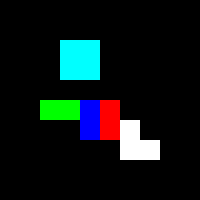

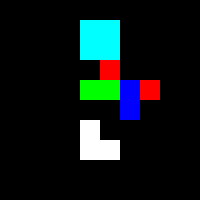

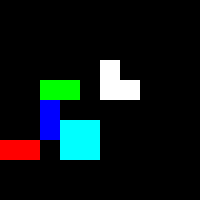

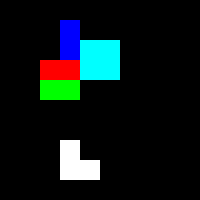

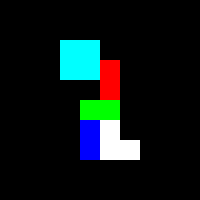

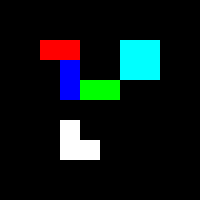

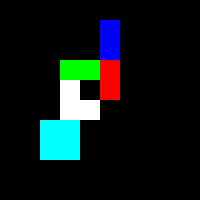

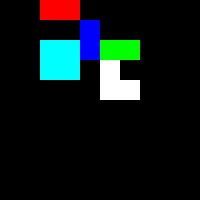

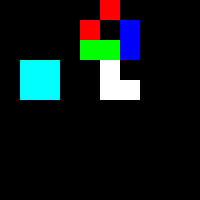

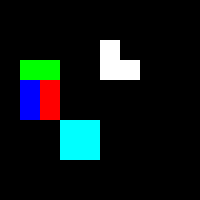

In [ ]:
output_img_1=L[0][19734].resize((200,200),resample=Image.BOX)
cv2_imshow(np.array(output_img_1))
print("\n\n\n")
output_img_2=L[1][37035].resize((200,200),resample=Image.BOX)
cv2_imshow(np.array(output_img_2))
print("\n\n\n")
output_img_3=L[2][5183].resize((200,200),resample=Image.BOX)
cv2_imshow(np.array(output_img_3))
print("\n\n\n")
output_img_4=L[3][457873].resize((200,200),resample=Image.BOX)
cv2_imshow(np.array(output_img_4))
print("\n\n\n")
output_img_5=L[4][44806].resize((200,200),resample=Image.BOX)
cv2_imshow(np.array(output_img_5))
print("\n\n\n")
output_img_6=L[5][35118].resize((200,200),resample=Image.BOX)
cv2_imshow(np.array(output_img_6))
print("\n\n\n")
output_img_7=L[6][169684].resize((200,200),resample=Image.BOX)
cv2_imshow(np.array(output_img_7))
print("\n\n\n")
output_img_8=L[7][138203].resize((200,200),resample=Image.BOX)
cv2_imshow(np.array(output_img_8))
print("\n\n\n")
output_img_9=L[8][2827].resize((200,200),resample=Image.BOX)
cv2_imshow(np.array(output_img_9))
print("\n\n\n")
output_img_10=L[9][223510].resize((200,200),resample=Image.BOX)
cv2_imshow(np.array(output_img_10))

In [ ]:
render_images=[]
for i in range(len(L[5])):
  output_img=L[5][i].resize((200,200),resample=Image.BOX)
  render_images.append(output_img)

drive.mount('/content/gdrive',force_remount=True)
os.chdir("/content/gdrive/MyDrive/Project_1")
sys.path.append("/content/gdrive/MyDrive/Project_1")

images=[]
for i in range(len(render_images)):
  imageio.imsave("abc_"+str(i)+".png",render_images[i])
  
for i in range(len(render_images)):  
  images.append(imageio.imread("abc_"+str(i)+".png"))
imageio.mimsave('/content/gdrive/MyDrive/Project_1/movie1.gif', images,fps=len(render_images))

#print(list(sorted(images, key=number))) 
#imageio.imread("abc_%d.png"%i)

Mounted at /content/gdrive


Download the GIFS created before.

In [ ]:
 files.download('/content/gdrive/MyDrive/Project/movie1.gif')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#DEEP -Q NETWORK-Using Keras rl


Importing required modules for building model

In [ ]:
!pip install tensorflow==2.3.1 gym keras-rl2 gym[atari]

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Convolution2D,MaxPooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras import metrics

Defining layers of neural network with input window shape(10x10x3)

In [ ]:
height,width,channels=finalobj.observation_space.shape
actions=finalobj.action_space.n

def build_model(height,width,channels, actions):
    model = Sequential()
    model.add(Convolution2D(64, (3,3),activation='relu', input_shape=(4,height,width,channels),padding='same'))
    model.add(Dropout(0.2))
    model.add(Convolution2D(64, (3,3), activation='relu',padding='same'))
    model.add(Dropout(0.2))
    model.add(Convolution2D(64, (3,3), activation='relu',padding='same'))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(actions, activation='linear'))
    return model

In [ ]:
del model

Creating object of the build neural network model

In [ ]:
model = build_model(height,width,channels, actions)

Checking the layers of the neural network model

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 4, 10, 10, 64)     1792      
_________________________________________________________________
dropout_3 (Dropout)          (None, 4, 10, 10, 64)     0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 4, 10, 10, 64)     36928     
_________________________________________________________________
dropout_4 (Dropout)          (None, 4, 10, 10, 64)     0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 4, 10, 10, 64)     36928     
_________________________________________________________________
dropout_5 (Dropout)          (None, 4, 10, 10, 64)     0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 25600)            

Importing DQN Agent required modules from keras rl

In [ ]:
from rl.agents import DQNAgent
from rl.memory import SequentialMemory
from rl.policy import LinearAnnealedPolicy, EpsGreedyQPolicy

Function to build DQN Agent

In [ ]:
def build_agent(model, actions):
    policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps', value_max=1., value_min=.1, value_test=.2, nb_steps=500000)
    memory = SequentialMemory(limit=50000, window_length=4)
    dqn = DQNAgent(model=model, memory=memory, policy=policy,
                  enable_dueling_network=True, dueling_type='avg', 
                   nb_actions=actions, nb_steps_warmup=10000
                  )
    return dqn

In [ ]:
dqn = build_agent(model, actions)
dqn.compile(optimizer=Adam(lr=1e-4),metrics=["accuracy"])
h=dqn.fit(finalobj, nb_steps=500000, visualize=False, verbose=2,log_interval=50000)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Training for 500000 steps ...
  30202/500000: episode: 1, duration: 486.249s, episode steps: 30202, steps per second:  62, episode reward: -51064.000, mean reward: -1.691 [-12.000,  1.000], mean action: 1.508 [0.000, 3.000],  loss: 1.685388, accuracy: 0.269810, mean_q: 9.193512, mean_eps: 0.963818
 111435/500000: episode: 2, duration: 1867.504s, episode steps: 81233, steps per second:  43, episode reward: -139715.000, mean reward: -1.720 [-14.000,  1.000], mean action: 1.496 [0.000, 3.000],  loss: 0.383704, accuracy: 0.264756, mean_q: -1.239779, mean_eps: 0.872528
 198465/500000: episode: 3, duration: 1984.242s, episode steps: 87030, steps per second:  44, episode reward: -147823.000, mean reward: -1.699 [-16.000,  1.000], mean action: 1.497 [0.000, 3.000],  loss: 0.317691, accuracy: 0.242040, mean_q: -10.086706, mean_eps: 0.721091
 211756/500000: episode: 4, duration: 302.025s, episode steps: 13291, steps per second:  44, episode reward: -22591.000, mean reward: -1.700 [-8.000,  1.000

In [ ]:
for key, value in h.history.items():
    print (key, value)

episode_reward [-51064.0, -139715.0, -147823.0, -22591.0, -24244.0, -15424.0, -13547.0, -15846.0, -34082.0, -51561.0, -6438.0, -90814.0, -18150.0, -102113.0]
nb_episode_steps [30202, 81233, 87030, 13291, 14421, 9196, 8178, 9225, 20902, 32202, 3917, 54867, 11260, 64348]
nb_steps [30202, 111435, 198465, 211756, 226177, 235373, 243551, 252776, 273678, 305880, 309797, 364664, 375924, 440272]


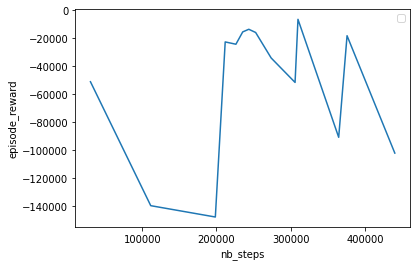

In [ ]:
x=h.history["nb_steps"]
y=h.history["episode_reward"]
plt.plot(x,y)
plt.xlabel('nb_steps')
plt.ylabel('episode_reward')
plt.legend()
plt.show()

In [ ]:
scores = dqn.test(finalobj, nb_episodes=10, visualize=False)

print(np.mean(scores.history['episode_reward']))

Testing for 10 episodes ...
Episode 1: reward: -86548.000, steps: 53951
Episode 2: reward: -71806.000, steps: 45125
Episode 3: reward: -108375.000, steps: 68759
Episode 4: reward: -67616.000, steps: 42210
Episode 5: reward: -45159.000, steps: 27505
Episode 6: reward: -15694.000, steps: 9732
Episode 7: reward: -233412.000, steps: 149678
Episode 8: reward: -221621.000, steps: 140182
Episode 9: reward: -1190.000, steps: 833
Episode 10: reward: -55990.000, steps: 35284
-90741.1


In [ ]:
for key, value in scores.history.items():
    print (key, value)

episode_reward [-383.0, 0.0, 0.0, -176.0, -38.0, 1.0, -162.0, -8.0, 0.0, -55.0]
nb_steps [224, 2, 2, 125, 34, 1, 111, 8, 2, 53]


No handles with labels found to put in legend.


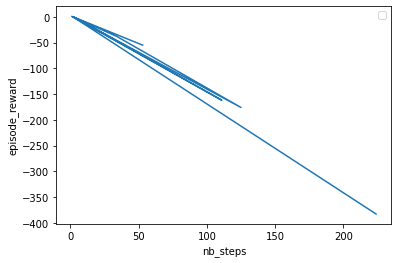

In [ ]:
x=scores.history["nb_steps"]
y=scores.history["episode_reward"]
plt.plot(x,y)
plt.xlabel('nb_steps')
plt.ylabel('episode_reward')
plt.legend()
plt.show()